In [ ]:
#Install the Google Cloud BigQuery library
!pip install --user google-cloud-bigquery==1.25.0

In [ ]:
# access files on google drive
from google.colab import drive
drive.mount('/content/drive')
# google auth
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [94]:
# import necessary library
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
# shutil offers a number of high-level operations on files and collections of files. 
# In particular, functions are provided which support file copying and removal.

In [95]:
# Provide project_id on Google Cloud Platform
project_id = 'xxxxxx'
# Provide client
client = bigquery.Client(project_id)

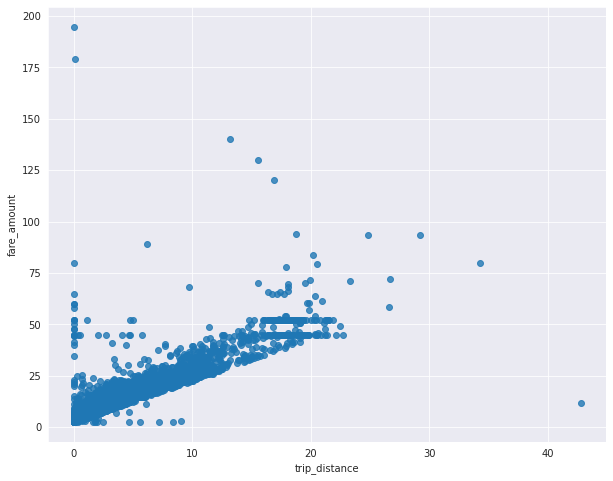

In [96]:
# Extract sample SQL data (nyc-tlc.yellow.trips) from BigQuery
# To properly sample the dataset, 
# let's use the HASH (FARM_FINGERPRINT) of the pickup time and return 1 in 100,000 records (MOD())
# because there are 1 billion records in the data, 
# we should get back approximately 10,000 records if we do this.
sql = """
  SELECT
    pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
"""
trips = client.query(sql).to_dataframe()

# explore this dataset and clean it up as necessary
# seaborn parameters: row = "", col =" ", col_wrap=2,sharex=True,sharey=False, aspect=1
# ci:confidence interval

ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10, 8)

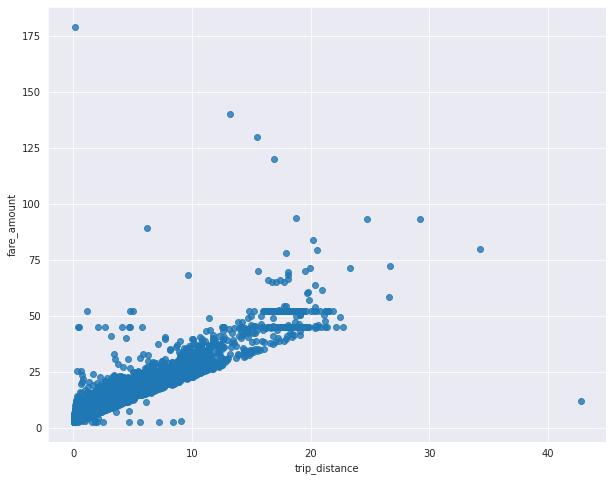

In [97]:
# Use Where function in SQL to remove invalid data such as zero distance with some fare amounts
sql = """
  SELECT
    pickup_datetime,
    pickup_longitude, pickup_latitude, 
    dropoff_longitude, dropoff_latitude,
    passenger_count,
    trip_distance,
    tolls_amount,
    fare_amount,
    total_amount
  FROM
    `nyc-tlc.yellow.trips`
  WHERE
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 100000)) = 1
    AND trip_distance > 0 AND fare_amount >= 2.5
"""

trips = client.query(sql).to_dataframe()
ax = sns.regplot(x="trip_distance", y="fare_amount", fit_reg=False, ci=None, truncate=True, data=trips)
ax.figure.set_size_inches(10, 8)

In [98]:
# Let's examine whether the toll amount is captured in the total amount.
#  the total amount reflects fare amount, toll and tip somewhat arbitrarily
tollrides = trips[trips['tolls_amount'] > 0]
# '\n' is for new line
# print("\n\n\n++++++++++++++++++examine the toll amount++++++++++++++++++++++++\n\n\n")
# print(tollrides[tollrides['pickup_datetime'] == '2010-04-29 12:28:00'])
# print("\n\n\n++++++++++++++++++examine statistic value++++++++++++++++++++++\n\n\n")
# print(trips.describe().T)
# The min, max of longitude look strange

In [99]:
#  look at the start and end of a few of the trips
# iterrows, items,itertuples
def showrides(df, numlines):
  lats = []
  lons = []
  # pick specific row
  for iter, row in df[:numlines].iterrows():
    lons.append(row['pickup_longitude'])
    lons.append(row['dropoff_longitude'])
    lons.append(None)
    lats.append(row['pickup_latitude'])
    lats.append(row['dropoff_latitude'])
    lats.append(None)

  sns.set_style("darkgrid")
  plt.figure(figsize=(10,8))
  plt.plot(lons, lats)

# showrides(trips, 10)
# showrides(tollrides, 10)

In [ ]:
# Quality control and other preprocessing
# New York city longitudes are around -74 and latitudes are around 41.
# We shouldn't have zero passengers.
# Clean up the total_amount column to reflect only fare_amount and tolls_amount, and then remove those two columns.
# Before the ride starts, we'll know the pickup and dropoff locations, but not the trip distance (that depends on the route taken), so remove it from the ML dataset
# Discard the timestamp
# In production, we'll have to carry out the same preprocessing on the real-time input data.
# This sort of preprocessing of input data is quite common in ML, especially if the quality-control is dynamic.
# np.all, return True if all true
# np.any, return False if all False
# axis=0 refers computing vertically, axis=1 refers computing horizontally
# Two or more physical lines may be joined into logical lines using backslash characters (\)
# The quality control has removed about 300 rows (11400 - 11101) or about 3% of the data. 

def preprocess(trips_in):
  trips = trips_in.copy(deep=True)
  trips.fare_amount = trips.fare_amount + trips.tolls_amount
  del trips['tolls_amount']
  del trips['total_amount']
  del trips['trip_distance']
  del trips['pickup_datetime']
  qc = np.all([\
             trips['pickup_longitude'] > -78, \
             trips['pickup_longitude'] < -70, \
             trips['dropoff_longitude'] > -78, \
             trips['dropoff_longitude'] < -70, \
             trips['pickup_latitude'] > 37, \
             trips['pickup_latitude'] < 45, \
             trips['dropoff_latitude'] > 37, \
             trips['dropoff_latitude'] < 45, \
             trips['passenger_count'] > 0,
            ], axis=0)
  return trips[qc]

tripsqc = preprocess(trips)
# print(tripsqc.describe())



In [100]:
# Create ML datasets
# split the QCed data randomly
# df.sample method, frac=1 refers 100% data row
# iloc 
# df_train takes all rows and columns from 0 to trainsize
shuffled = tripsqc.sample(frac=1)
trainsize = int(len(shuffled['fare_amount']) * 0.70)
validsize = int(len(shuffled['fare_amount']) * 0.15)

df_train = shuffled.iloc[:trainsize, :]
df_valid = shuffled.iloc[trainsize:(trainsize+validsize), :]
df_test = shuffled.iloc[(trainsize+validsize):, :]
# print("\n\n\n++++++++++++++++++df_train summary++++++++++++++++++++++++\n\n\n")
# print(df_train.describe())
# print("\n\n\n++++++++++++++++++df_valid summary++++++++++++++++++++++++\n\n\n")
# print(df_valid.describe())
# print("\n\n\n++++++++++++++++++df_test summary++++++++++++++++++++++++\n\n\n")
# print(df_test.describe())


In [101]:
# loc 
# data.loc[['Index1','Index4'],['Columns1','Columns4']] (index1,index4, columns1, columns4)
# data.loc['Index1':'Index2','Columns1':'Columns3'] (index1 to index2, columns1 to columns3)
# data.loc['Index1':'Index2',:] (index1 to index2, all columns)
def to_csv(df, filename):
  outdf = df.copy(deep=False)
  # add column 'key' and assign value from 0 to the len(outdf)
  outdf.loc[:, 'key'] = np.arange(0, len(outdf)) # rownumber as key
  # reorder columns so that target is first column
  cols = outdf.columns.tolist()
  cols.remove('fare_amount')
  # insert column name 'fare_amount' as first column 0
  cols.insert(0, 'fare_amount')
  print (cols)  # new order of columns
  # dataset with new order
  outdf = outdf[cols]
  # generate csv file with no header, no index_label, no index
  outdf.to_csv(filename, header=False, index_label=False, index=False)

to_csv(df_train, 'taxi-train.csv')
to_csv(df_valid, 'taxi-valid.csv')
to_csv(df_test, 'taxi-test.csv')

['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']
['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'key']


In [138]:
# !head -10 taxi-valid.csv
# !ls -l *.csv
# call bash command, %%bash, or !
%%bash
head taxi-train.csv

8.9,-73.987222,40.765982,-73.993082,40.737527,1,0
6.0,-73.987616,40.76219,-73.986832,40.775833,1,1
87.5,-74.01601,40.71158,-74.179392,40.711652,5,2
6.0,-73.982321,40.774314,-73.980401,40.780536,1,3
6.1,-73.969197,40.764832,-73.980742,40.774061,2,4
7.5,-73.964462,40.80728,-73.96696,40.788797,1,5
3.7,-73.96704,40.757425,-73.97415,40.757295,5,6
6.9,-73.986255,40.734537,-73.991272,40.750248,1,7
20.5,-73.954433,40.784147,-73.984113,40.756299,1,8
5.3,-73.954578,40.765587,-73.96541,40.766765,5,9


In [139]:
# divide the mean fare_amount by the mean trip_distance to come up with a rate and use that to predict
# get Root Mean Square Error RMSE
def distance_between(lat1, lon1, lat2, lon2):
  # haversine formula to compute distance "as the crow flies". 
  # S=R·arc cos[cosβ1cosβ2cos（α1-α2）+sinβ1sinβ2]
  dist = np.degrees(np.arccos(np.minimum(1,np.sin(np.radians(lat1)) * np.sin(np.radians(lat2)) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.cos(np.radians(lon2 - lon1))))) * 60 * 1.515 * 1.609344
  return dist

def estimate_distance(df):
  return distance_between(df['pickuplat'], df['pickuplon'], df['dropofflat'], df['dropofflon'])

def compute_rmse(actual, predicted):
  return np.sqrt(np.mean((actual-predicted)**2))

def print_rmse(df, rate, name):
  # variable 1, 0
  print ("{1} RMSE = {0}".format(compute_rmse(df['fare_amount'], rate*estimate_distance(df)), name))

FEATURES = ['pickuplon','pickuplat','dropofflon','dropofflat','passengers']
TARGET = 'fare_amount'
columns = list([TARGET])
columns.extend(FEATURES) # in CSV, target is the first column, after the features
columns.append('key')
# use columns for columns in following dataframe
df_train = pd.read_csv('taxi-train.csv', header=None, names=columns)
df_valid = pd.read_csv('taxi-valid.csv', header=None, names=columns)
df_test = pd.read_csv('taxi-test.csv', header=None, names=columns)
rate = df_train['fare_amount'].mean() / estimate_distance(df_train).mean()
print ("Rate = ${0}/km".format(rate))
print_rmse(df_train, rate, 'Train')
print_rmse(df_valid, rate, 'Valid') 
print_rmse(df_test, rate, 'Test') 

Rate = $2.588365741996462/km
Train RMSE = 7.014366893123038
Valid RMSE = 7.880424577228827
Test RMSE = 9.489749361953297


In [140]:
def create_query(phase, EVERY_N):
  """
  phase: 1=train 2=valid
  """
  base_query = """
SELECT
  (tolls_amount + fare_amount) AS fare_amount,
  CONCAT(CAST(pickup_datetime AS STRING), CAST(pickup_longitude AS STRING), CAST(pickup_latitude AS STRING), CAST(dropoff_latitude AS STRING), CAST(dropoff_longitude AS STRING)) AS key,
  EXTRACT(DAYOFWEEK FROM pickup_datetime)*1.0 AS dayofweek,
  EXTRACT(HOUR FROM pickup_datetime)*1.0 AS hourofday,
  pickup_longitude AS pickuplon,
  pickup_latitude AS pickuplat,
  dropoff_longitude AS dropofflon,
  dropoff_latitude AS dropofflat,
  passenger_count*1.0 AS passengers
FROM
  `nyc-tlc.yellow.trips`
WHERE
  trip_distance > 0
  AND fare_amount >= 2.5
  AND pickup_longitude > -78
  AND pickup_longitude < -70
  AND dropoff_longitude > -78
  AND dropoff_longitude < -70
  AND pickup_latitude > 37
  AND pickup_latitude < 45
  AND dropoff_latitude > 37
  AND dropoff_latitude < 45
  AND passenger_count > 0
  """

  if EVERY_N == None:
    if phase < 2:
      # training
      query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 4)) < 2".format(base_query)
    else:
      query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 4)) = {1}".format(base_query, phase)
  else:
      query = "{0} AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), {1})) = {2}".format(base_query, EVERY_N, phase)
    
  return query

query = create_query(2, 100000)
df_valid = client.query(query).to_dataframe()
print_rmse(df_valid, 2.56, 'Final Validation Set')

Final Validation Set RMSE = 7.4158766166380445
